In [1]:
using LinearAlgebra
using Statistics
using Plots
using StatsPlots
using BenchmarkTools

In [2]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,dim,dim);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

function get_diag(A::Matrix)::Array #get diagonal as vector
    dim = size(A,1)
    diag = Array{Float64}(undef, dim)
    for i=1:dim
        diag[i] = A[i,i]
    end
    return diag
end

get_diag (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [3]:
function power_eigen(A::Matrix, iterations::Integer)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    results = Float64[];
    eig = nothing;
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        eig = x' * A * x1 / (x' * x1);
        push!(results, eig[1]);
    end
    return eig, results;
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

function power_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-6)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    eig = nothing
    
    for i = 1:max_iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        
        new_eig = x' * A * x1 / (x' * x1)

        if eig != nothing && abs(new_eig[1] - eig) < error
            return new_eig, x
        end
        eig = new_eig[1]
    end
    return eig, x
end

power_eigen_stop (generic function with 3 methods)

In [4]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ, _ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);
display(v)
e, v = power_eigen_stop(A)
display(e)
display(v)

1×1 Array{Float64,2}:
 110.72104716449108

1×1 Array{Float64,2}:
 -16.354712445616492

5-element Array{Float64,1}:
 -21.94799098740289
 -16.35465742492989
  27.731780174607035
  37.84982107323455
 110.72104716449094

5×5 Array{Float64,2}:
  0.449645    0.353109  -0.635503  -0.145226  0.498174
  0.0810637   0.352271   0.719548  -0.31241   0.50397
 -0.734533    0.410392  -0.148941   0.420705  0.304735
 -0.312706   -0.711641  -0.123596  -0.289918  0.544476
  0.392332   -0.276342   0.202306   0.787568  0.329423

1×1 Array{Float64,2}:
 110.72104712582106

5×1 Array{Float64,2}:
 0.49817249577543193
 0.5039653748301006
 0.30474058182340447
 0.5444720597042153
 0.32943348253724253

In [5]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  20.201 μs (168 allocations: 17.67 KiB)
  16.201 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza się z wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [6]:
B = A' * A;
λₘₐₓ, _ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash, _ = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [7]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[6.420626938031666]

6.770001002632786

# Metoda Jacobiego

In [4]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    n = size(A,1);
    results = Float64[];
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
        
    end
    return A, results
end

function jacobi_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    n = size(A,1);
    eigs = nothing
    eigenVectors = eye(n)
    for i = 1:max_iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R;
        
        new_eigs = get_diag(A)
        eigenVectors = eigenVectors*R
        if eigs != nothing && !any(broadcast(abs, new_eigs .- eigs) .> error)
            return new_eigs, eigenVectors
        end
        eigs = new_eigs
        
    end
    return eigs, eigenVectors
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [58]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(10,true);
FJ, _ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ);

#display(FJ)
e,v = eigen(F);
display(e)
display(v)
e,v = jacobi_eigen_stop(F)
display(e)
display(v)

10×10 Array{Float64,2}:
  5.0  22.0  15.0  14.0  31.0  40.0  36.0  44.0  34.0  19.0
 22.0   7.0  25.0  41.0  16.0  37.0  27.0  19.0  13.0  17.0
 15.0  25.0  34.0  23.0  38.0  19.0  19.0  31.0  39.0  24.0
 14.0  41.0  23.0  46.0   3.0  50.0  49.0  27.0  10.0  21.0
 31.0  16.0  38.0   3.0   4.0  35.0  21.0  41.0  19.0  48.0
 40.0  37.0  19.0  50.0  35.0  44.0  43.0  41.0   2.0  28.0
 36.0  27.0  19.0  49.0  21.0  43.0   1.0   3.0  15.0  46.0
 44.0  19.0  31.0  27.0  41.0  41.0   3.0  36.0  40.0  16.0
 34.0  13.0  39.0  10.0  19.0   2.0  15.0  40.0  17.0  11.0
 19.0  17.0  24.0  21.0  48.0  28.0  46.0  16.0  11.0   1.0

10-element Array{Float64,1}:
 -63.88381960067204
 -53.1619663685877
 -40.5930652151384
 -24.35301469840804
 -15.001076107977937
   0.9960655289579137
  25.415223217634335
  26.087468909424544
  71.96127514418114
 267.5329091905861

10×10 Array{Float64,2}:
 -0.367154   -0.174424    0.577064   …   0.266296    0.144403   -0.309569
  0.0344077   0.0662515  -0.0755006     -0.20703    -0.190649   -0.275112
 -0.07044     0.137598    0.283743      -0.50264     0.322806   -0.305715
 -0.162295   -0.349799    0.0889359     -0.45339    -0.509988   -0.34807
  0.292718   -0.67168    -0.0415823      0.321596    0.258093   -0.302839
 -0.0897579   0.0522774  -0.396969   …   0.385749   -0.309366   -0.413454
  0.656551    0.28146     0.149656       0.0116283  -0.285492   -0.310798
  0.207551    0.393268    0.114574       0.134372    0.369851   -0.352865
 -0.0181624  -0.113402   -0.587826      -0.340106    0.4439     -0.231142
 -0.514301    0.351096   -0.180279       0.204758   -0.0291101  -0.276902

10-element Array{Float64,1}:
 267.5258138128666
  71.96324410650527
  25.946610716335762
   0.9087636016372265
  25.501241046215064
 -15.031305005785912
 -24.274750458365073
 -53.13411071569297
 -40.55672361263156
 -63.84878349108456

10×10 Array{Float64,2}:
 -0.308447  -0.145784  -0.321065   …  -0.183978    0.578939   -0.385482
 -0.276891   0.189511   0.159228       0.0516114  -0.0395348   0.0421049
 -0.307258  -0.323322   0.589112       0.128609    0.272869   -0.0791587
 -0.350886   0.507779   0.316331      -0.346831    0.0600946  -0.171657
 -0.301803  -0.259002  -0.150922      -0.664733   -0.0465349   0.291283
 -0.411776   0.308572  -0.44602    …   0.0546405  -0.404026   -0.0714077
 -0.312459   0.285274   0.123791       0.279971    0.182265    0.650579
 -0.350437  -0.371681  -0.344809       0.396002    0.11108     0.202284
 -0.229379  -0.444768   0.255589      -0.110029   -0.578272    0.00228846
 -0.27743    0.028486   0.0564955      0.366734   -0.199596   -0.509683

In [10]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  20.299 μs (65 allocations: 42.09 KiB)


# QR algorithm

In [28]:
function QR_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    results = Float64[];
    n = size(A,1);
    Q = zeros(n,n);
    R = zeros(n,n);
    for k = 1:iterations
        mgs!(Q, R, A);
        A = R * Q;
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
        zeros!(Q,n);
        zeros!(R,n);
    end
    return A, results;
end

function QR_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    eigs = nothing
    n = size(A,1);
    pQ = eye(n);
    Q = zeros(n,n);
    R = zeros(n,n);
    for k = 1:max_iterations
        mgs!(Q, R, A);
        A = R * Q;
        pQ = pQ * Q
        new_eigs = get_diag(A)
        if eigs != nothing && !any(x -> x > error, broadcast(abs, new_eigs .- eigs)) 
            return new_eigs, pQ
        end
        eigs = new_eigs
        zeros!(Q,n);
        zeros!(R,n);
    end
    return eigs, pQ;
end

function mgs!(Q::Matrix, R::Matrix, A::Matrix)
    n = size(A,1);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end
end

function zeros!(X::Matrix, n::Integer)
    X[X .!= 0] .= 0;
    #for i=1:n
    #    for j=1:n
    #       X[i,j] = 0.0; 
    #    end
    #end
end

zeros! (generic function with 2 methods)

In [12]:
A = symmetric_matrix(5);
AQR, _ = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)
display(v)
e, v = QR_eigen_stop(A);
display(e)
display(v)

5×5 Diagonal{Float64,Array{Float64,1}}:
 119.197    ⋅         ⋅        ⋅       ⋅ 
    ⋅     47.6975     ⋅        ⋅       ⋅ 
    ⋅       ⋅      -43.8102    ⋅       ⋅ 
    ⋅       ⋅         ⋅      15.4198   ⋅ 
    ⋅       ⋅         ⋅        ⋅      5.49568

5-element Array{Float64,1}:
 -43.928455277760264
   5.495681632305903
  15.419839918840182
  47.815734024107655
 119.19719970250684

5×5 Array{Float64,2}:
  0.166107  -0.586654   0.0387879  -0.75239   -0.246274
 -0.408605  -0.346712   0.690108    0.332046  -0.355427
 -0.109663  -0.321006  -0.679451    0.366914  -0.53726
 -0.443959   0.609372  -0.0272872  -0.405661  -0.516004
  0.77222    0.247485   0.244637    0.156423  -0.508047

5-element Array{Float64,1}:
 119.19719970250681
  47.765047013617036
 -43.87776826726981
  15.419839918840148
   5.49568163230581

5×5 Array{Float64,2}:
 0.246274  -0.748277  -0.183746  -0.0387879  -0.586654
 0.355427   0.32235    0.416297  -0.690108   -0.346712
 0.53726    0.364235   0.118257   0.679451   -0.321006
 0.516004  -0.415984   0.434302   0.0272872   0.609372
 0.508047   0.174531  -0.76833   -0.244637    0.247485

In [31]:
A = symmetric_matrix(5);
@benchmark QR_eigen_stop(A)

BenchmarkTools.Trial: 
  memory estimate:  439.06 KiB
  allocs estimate:  3357
  --------------
  minimum time:     184.100 μs (0.00% GC)
  median time:      188.199 μs (0.00% GC)
  mean time:        206.683 μs (6.83% GC)
  maximum time:     1.927 ms (76.35% GC)
  --------------
  samples:          10000
  evals/sample:     1

# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [100]:
function plot_eigenvalues(PlotA::Matrix, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    x = 1:max_iterations;
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    if !err
        results_eig = zeros(0);
        for i = x
            append!(results_eig, eigen_lambda);
        end
    end

    #power method
    _, results_power = power_eigen(PlotA, max_iterations);
    if err
        results_power = broadcast(abs, results_power .- eigen_lambda);
        #results_power = abs.(results_power - eigen_lambda);
    end

    # jacobi algorithm
    _, results_jacobi = jacobi_eigen(PlotA, max_iterations);
    if err
        results_jacobi = broadcast(abs, results_jacobi .- eigen_lambda);
    end

    # QR algorithm
    _, results_qr = QR_eigen(PlotA, max_iterations);
    if err
        results_qr = broadcast(abs, results_qr .- eigen_lambda);
    end


    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end

end

plot_eigenvalues (generic function with 3 methods)

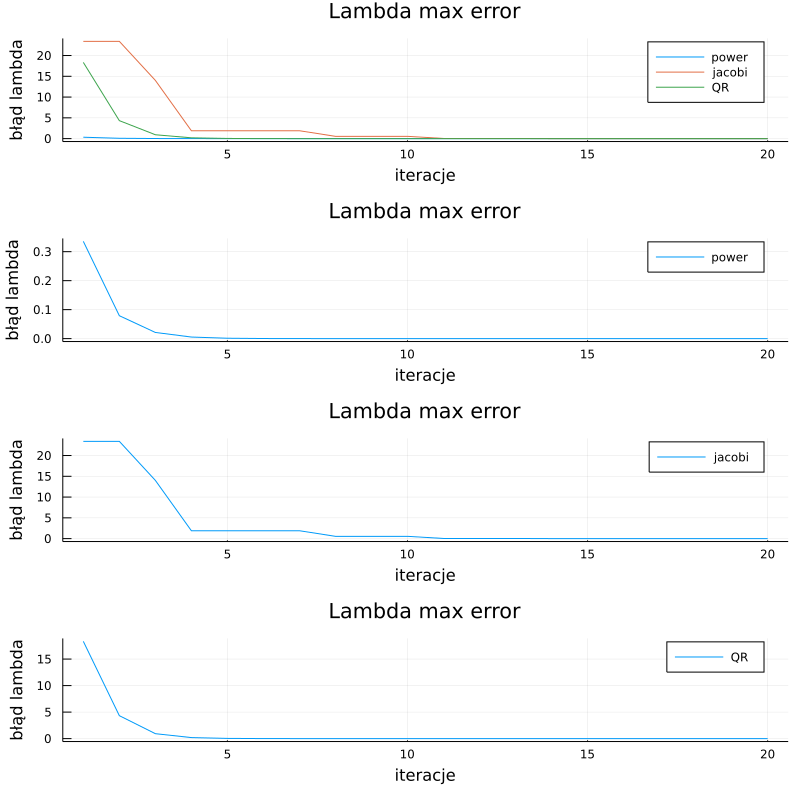

In [101]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 20, true, true);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

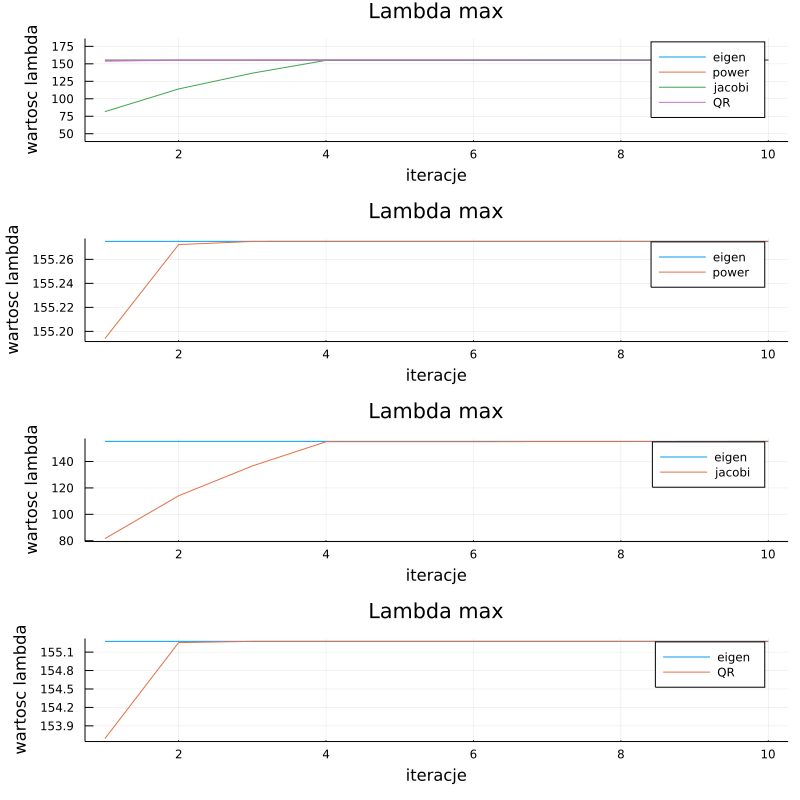

  0.152922 seconds (199.37 k allocations: 9.441 MiB)


In [16]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 10, true)

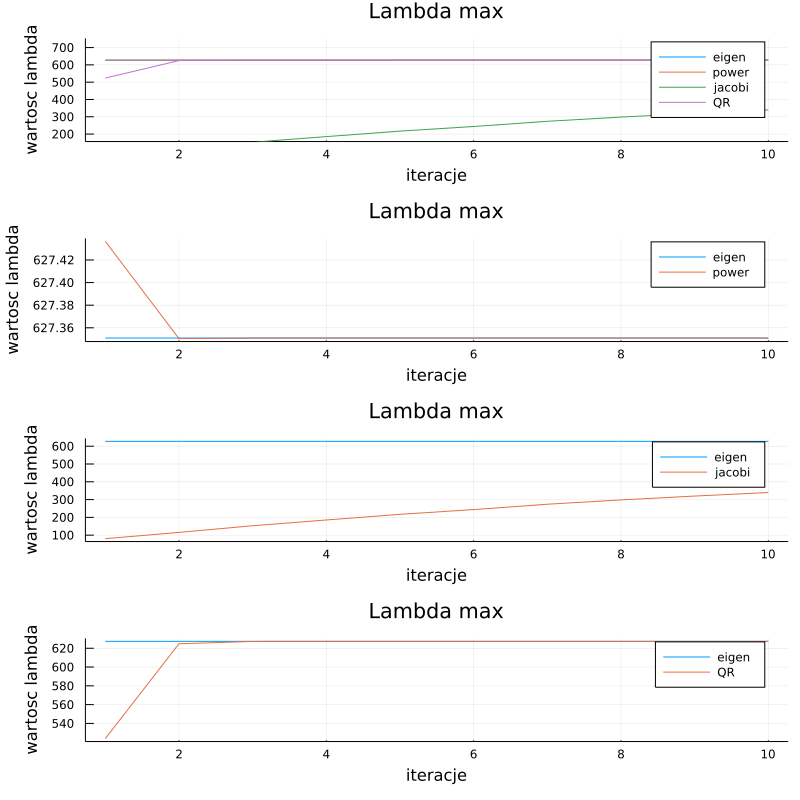

  0.065719 seconds (127.80 k allocations: 8.713 MiB)


In [17]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 10, true)

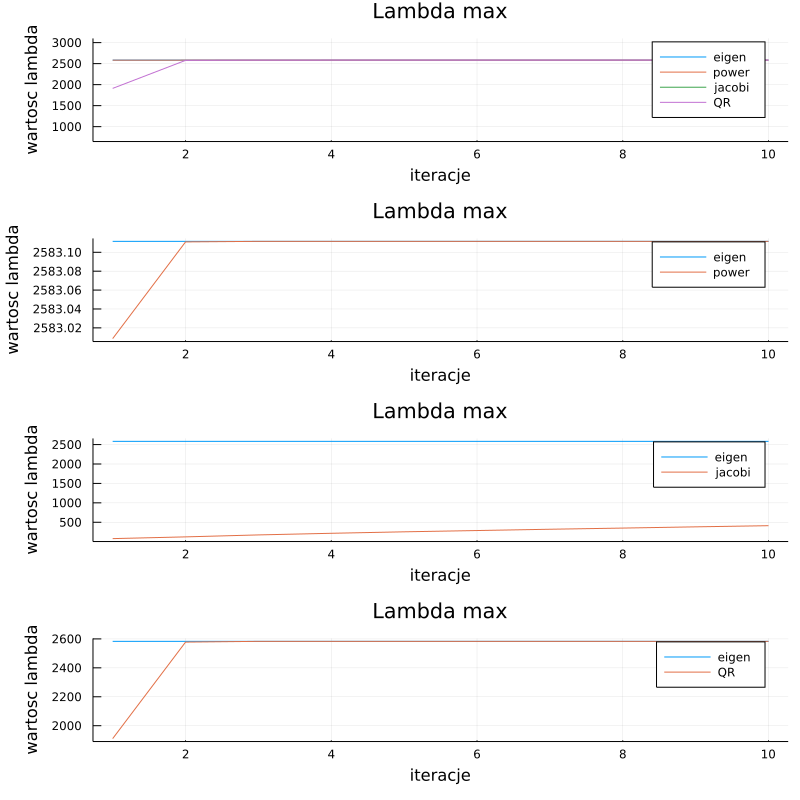

  0.275236 seconds (315.62 k allocations: 180.749 MiB, 21.85% gc time)


In [18]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 10, true)

Benchmarki dla wszystkich metod przy 3 rozmiarach macierzy:

In [19]:
A = symmetric_matrix(10)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A)
print("Eigen: ")
@btime eigen(A);

Power:   9.799 μs (66 allocations: 7.69 KiB)
QR:   438.700 μs (8073 allocations: 1.34 MiB)
Eigen:   69.300 μs (11 allocations: 6.88 KiB)


In [20]:
A = symmetric_matrix(25)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A)
print("Eigen: ")
@btime eigen(A);

Power:   11.999 μs (50 allocations: 8.19 KiB)
QR:   74.855 ms (732831 allocations: 212.17 MiB)
Eigen:   438.800 μs (11 allocations: 25.00 KiB)


In [21]:
A = symmetric_matrix(100)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A)
print("Eigen: ")
@btime eigen(A);

Power:   75.201 μs (42 allocations: 16.38 KiB)
QR:   5.259 s (20011002 allocations: 16.99 GiB)
Eigen:   4.275 ms (14 allocations: 272.09 KiB)


In [22]:
A = symmetric_matrix(100)
@benchmark QR_eigen_stop(A)

BenchmarkTools.Trial: 
  memory estimate:  16.99 GiB
  allocs estimate:  20011002
  --------------
  minimum time:     5.243 s (15.84% GC)
  median time:      5.243 s (15.84% GC)
  mean time:        5.243 s (15.84% GC)
  maximum time:     5.243 s (15.84% GC)
  --------------
  samples:          1
  evals/sample:     1

In [23]:
# plot time benchmarks
#plot for [x1, x2, x3...] iterations
# plot_mean_time(A, [5, 10]);
function plot_mean_time(A::Matrix, iterations::Array, sample::Integer=2000)

    n = size(iterations,1);
    results = zeros(1);
    nam = [];

    for i = 1:n
        power = @benchmark  power_eigen(A, $iterations[$i]) samples = sample;
        power = mean(power.times)/1000;
        jacobi = @benchmark jacobi_eigen(A, $iterations[$i]) samples = sample;
        jacobi = mean(jacobi.times)/1000;
        qr = @benchmark QR_eigen(A, $iterations[$i]) samples = sample;
        qr = mean(qr.times)/1000;
        results = hcat(results, power, jacobi, qr);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
    end
    results = results[2:end];
    ctg = repeat(["Power", "Jacobi", "QR"], outer = n)
    
    plot_time = groupedbar(nam, results, group = ctg, xlabel = "Liczba iteracji", ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod dla okreśłonej liczby iteracji", bar_width = 0.67,
        lw = 0, framestyle = :box)
    display(plot_time);
    
end

# plot to reach stop condition
function plot_mean_time(A::Matrix, sample::Integer=5000)
    power = @benchmark  power_eigen_stop(A) samples = sample;
    power = mean(power.times)/1000;
    jacobi = @benchmark jacobi_eigen_stop(A) samples = sample;
    jacobi = mean(jacobi.times)/1000;
    qr = @benchmark QR_eigen_stop(A) samples = sample;
    qr = mean(qr.times)/1000;

    results = [power, jacobi, qr];
    nam = repeat(["time"], inner=3);
    ctg = repeat(["Power", "Jacobi", "QR"], outer = 1)

    display(results);

    plot_time = groupedbar(nam, results, group = ctg, ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod do warunku stopu", bar_width = 0.67,
        lw = 0, framestyle = :box);
    display(plot_time);
end

plot_mean_time (generic function with 4 methods)

3-element Array{Float64,1}:
   9.42660448
  24.6304312
 184.6063464

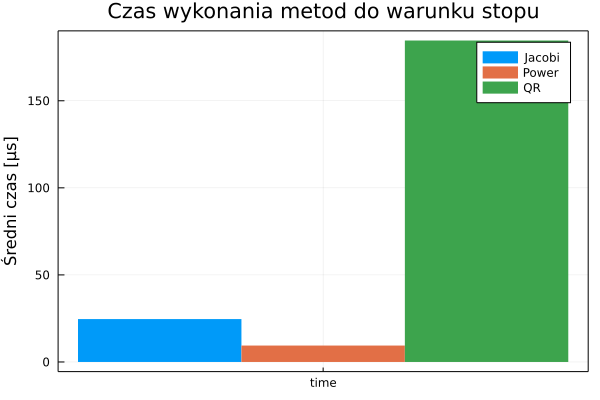

In [24]:
A = symmetric_matrix(5);
plot_mean_time(A);

# Zastosowanie

In [25]:
function eigen_PCA(eigen_func::Function, X::Matrix, K::Integer)::Matrix
    if K <=0 || K > size(X,2)
        throw(DomainError("K must be between 1 and number of columns"))
    end
    X = X - repeat(mean.(eachcol(X)), 1, size(X, 1))'
    Rxx = X' * X/length(X[1,:])
    d, v = eigen_func(Rxx)
    if eigen_func == eigen
        v = reverse(v, dims=2)
        d = reverse(d)
    end
    Rxx_hat = zeros(size(Rxx,1),size(Rxx,2))

    for i = 1:K
     Rxx_hat = Rxx_hat + d[i] * v[:,i] * v[:,i]'
    end

    Error_Rxx = norm(Rxx - Rxx_hat)
    display(Error_Rxx)
    W = v[:,1:K]'
    Y = W * X';
    X_hat = W' * Y;
    Error_X = norm(X' - X_hat)
    display(Error_X)
    return Y
end

eigen_PCA (generic function with 1 method)

In [26]:
# eigen jacobi_eigen_stop QR_eigen_stop
X = Matrix([sin.(pi * (1:6)/2) cos.(pi * (1:6)/4) rand(6,20)]')
display(X)
Y = eigen_PCA(eigen, X, 4)
display(Y)

22×6 Array{Float64,2}:
 1.0        1.22465e-16  -1.0         -2.44929e-16   1.0         3.67394e-16
 0.707107   6.12323e-17  -0.707107    -1.0          -0.707107   -1.83697e-16
 0.131805   0.969432      0.324754     0.476664      0.654197    0.947338
 0.190361   0.471621      0.157156     0.806761      0.56394     0.169316
 0.686327   0.0583066     0.909884     0.120243      0.102549    0.3279
 0.742034   0.454538      0.805093     0.234347      0.16322     0.830704
 0.0414206  0.457992      0.0568753    0.641335      0.405668    0.0920045
 0.965672   0.424882      0.192507     0.115207      0.103198    0.84551
 0.949866   0.0127564     0.00777816   0.625964      0.525128    0.307498
 0.954085   0.782761      0.837919     0.746717      0.192656    0.277371
 0.707704   0.741466      0.0758688    0.778579      0.941196    0.626781
 0.108529   0.546095      0.533119     0.437107      0.172552    0.777659
 0.982229   0.968527      0.768179     0.927905      0.218132    0.909886
 0.573723  

0.25004334366878705

1.4017661715248224

4×22 Array{Float64,2}:
  1.32416     2.08046   -0.403369  …  -0.0367308   -0.0904731  -0.374513
 -1.05111     0.658125  -0.187224     -0.00694021  -0.300927   -0.346948
  0.0833278   0.257531   0.493851     -0.504736    -0.262631   -0.431197
  0.3409     -0.27115   -0.541749     -0.240374     0.0732985   0.271106

In [27]:
function eigen_SVD(eigen_func::Function, A::Matrix)::Tuple{Matrix, Matrix, Matrix}
    ATA = A'*A
    d, V = eigen_func(ATA)
    display(d)
#    d = reverse(d)
#    V = reverse(V, dims=2)
    s = sqrt.(d)
    S = Diagonal(s)
    S1 = inv(S)
    U = A * V * S1

    return U, S, V
end

eigen_SVD (generic function with 1 method)

In [28]:
#A = [4 0; 3 -5]
A = symmetric_matrix(5)
display(A)
U, S, V = eigen_SVD(eigen, A)
newA = U * S * V'
display(newA)

5×5 Array{Float64,2}:
  7.0  19.0  37.0  39.0   3.0
 19.0  17.0  37.0  16.0  33.0
 37.0  37.0  19.0  38.0  40.0
 39.0  16.0  38.0  43.0  44.0
  3.0  33.0  40.0  44.0  22.0

5-element Array{Float64,1}:
    60.91506731154858
   312.87518254157214
   581.8454202506382
  1792.6998195774029
 22191.66451031884

5×5 Array{Float64,2}:
  7.0  19.0  37.0  39.0   3.0
 19.0  17.0  37.0  16.0  33.0
 37.0  37.0  19.0  38.0  40.0
 39.0  16.0  38.0  43.0  44.0
  3.0  33.0  40.0  44.0  22.0